<a href="https://colab.research.google.com/github/BogdanT54/Statistica-Pietelor-Financiare/blob/main/Proiect_SPF_Solana_Palantir_Gold.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Cerințe pentru proiectul la disciplina Statistica piețelor financiare – CSIE, anul III
- Proiectul se poate realiza în echipe de cel mult patru persoane și cel puțin două persoane.
- În realizarea proiectului, alegeți trei serii de date OHLC (zilnice sau săptămînale) pentru: o
acțiune, o criptomonedă și un alt activ financiar.
- Scopul proiectului este realizarea profilului de risc al celor trei active financiare, atît
individual, cît și pentru portofoliul ce include cele trei active financiare (ponderile activelor
în portofoliu pot fi egale sau alese pe diverse criterii de optimalitate).
- Structura proiectului trebuie să fie următoarea:
o Prezentarea subiectului, cu exemplificare din literatura de specialitate
o Surse de date
o Model/modele econometrice folosite
o Concluzii și interpretări
o Bibliografie
- În realizarea proiectului se va avea în vederea ilustrarea următoarelor concepte/metode:
• Verificarea proprietăților distribuției randamentelor
• Estimarea probabilităților unor randamente extreme
• Ipoteza de piață eficientă în forma slabă
• Ipoteza de piață fractală
• Modele cu volatilitate stohastică de tip GARCH
• Value at risk pe rolling windows

In [67]:
!pip install numpy pandas matplotlib seaborn yfinance statsmodels scipy arch nolds requests pingouin

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.4/204.4 kB 393.0 kB/s eta 0:00:00


In [87]:
# 📦 Baze generale pentru manipulare și vizualizare
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 📈 Obținerea datelor financiare
import yfinance as yf

# 📊 Analiza statistică
from scipy import stats
from scipy.stats import skew, kurtosis
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.stattools import jarque_bera

# 📉 Modele de volatilitate (GARCH)
from arch import arch_model
from arch.unitroot import ADF, PhillipsPerron, KPSS

# 💰 Calcularea Value-at-Risk (VaR)
from statsmodels.distributions.empirical_distribution import ECDF

# 🔁 Rolling window + regresii
from statsmodels.regression.rolling import RollingOLS
import statsmodels.api as sm

# 📐 Ipoteza pieței fractale – exponentul Hurst
import nolds

# ⏳ Setări grafice suplimentare
import matplotlib.dates as mdates

import pingouin as pg

In [144]:
#Descarcam datele din ultimii 5 ani pentru Solana, Palantir, Gold

solana = yf.download('SOL-USD', period='5y', interval='1d')
palantir = yf.download('PLTR', period='5y', interval='1d')
gold = yf.download('GC=F', period='5y', interval='1d')

#Salvare date ca fisiere CSV
solana.to_csv('solana.csv')
palantir.to_csv('palantir.csv')
gold.to_csv('gold.csv')

#Verific datele
solana.head(-1)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,SOL-USD,SOL-USD,SOL-USD,SOL-USD,SOL-USD
Date,,,,,
2020-05-04,0.667491,0.705812,0.618434,0.679625,3443698
2020-05-05,0.641837,0.686214,0.626499,0.673440,2847469
2020-05-06,0.622584,0.673891,0.622584,0.642454,2677563
2020-05-07,0.612978,0.632268,0.573376,0.622584,3355830
2020-05-08,0.604922,0.636618,0.589852,0.612978,2488195
...,...,...,...,...,...
2025-04-29,146.427872,150.044189,145.169327,147.809937,2872743502
2025-04-30,147.643204,148.209290,140.712097,146.427490,3017472875


# **Solana (SOL)**

Tehnic: Solana este o criptomonedă și un blockchain de înaltă performanță, cunoscut pentru capacitatea sa de a procesa peste 65.000 de tranzacții pe secundă datorită consensului Proof of History (PoH) combinat cu Proof of Stake (PoS). Acest sistem reduce semnificativ latența și comisioanele de tranzacționare.
Economic: Cu o capitalizare de piață de peste 76 miliarde USD (mai 2025), Solana este considerat un concurent major pentru Ethereum în sectorul DeFi (finanțe descentralizate) și NFT-uri. Prețul actual este de ~146 USD, în scădere față de ATH-ul de 293 USD.
Practic: Este utilizat în aplicații descentralizate (DApps), piețe NFT, plăți rapide și tranzacții eficiente pe bursele crypto. Popularitatea sa în rândul dezvoltatorilor îl face o platformă atractivă pentru inovații blockchain.

# **Palantir Technologies (PLTR)**

Tehnic: Palantir este o companie de software care oferă soluții avansate de analiză a datelor, folosind inteligență artificială și machine learning. Tehnologia sa este orientată către integrarea, analiza și vizualizarea unor seturi de date masive, structurate sau nu.
Economic: PLTR este listată la NYSE și este o acțiune de tip growth (creștere), adesea influențată de așteptările privind contractele guvernamentale și adopția în sectorul privat. Dinamica sa bursieră este volatilă, iar randamentele trebuie analizate prin indicatori precum log-rentabilitatea, date fiind variațiile abrupte de preț.
Practic: Softurile sale (ex. Palantir Gotham și Foundry) sunt folosite în apărare, sănătate, energie, finanțe, contribuind la luarea deciziilor complexe, bazate pe modele predictive și simulări în timp real.

# **Gold (Aur)**

Tehnic: Aurul (tranzacționat sub simbolul GC=F pe piețele futures) este un activ fizic cu lichiditate ridicată, prețuit în funcție de cererea și oferta globală, geopolitică, inflație și dobânzi. Din punct de vedere al seriilor de timp, evoluția sa este adesea modelată ca proces stochastic (ex. random walk) și analizată prin ARIMA sau modele GARCH pentru volatilitate.
Economic: Este un „refugiu” tradițional în perioade de incertitudine economică. Nu produce cash-flow, dar este un activ cu rol de protecție contra inflației și instabilității monetare.
Practic: Este folosit atât ca activ de investiție (ETF-uri, contracte futures), cât și în industrie (electronică, bijuterii) și pentru diversificarea portofoliilor, având o corelație negativă față de acțiuni în momente de criză.

In [145]:
# Log randamente + Interpolation (linear)

solana_log = np.log(solana / solana.shift(1)).replace([np.inf, -np.inf], np.nan).dropna()
palantir_log = np.log(palantir / palantir.shift(1)).replace([np.inf, -np.inf], np.nan).dropna()
gold_log = np.log(gold / gold.shift(1)).replace([np.inf, -np.inf], np.nan).dropna()

#Verific datele
solana_log.head(-1)

/usr/local/lib/python3.11/dist-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


Price,Close,High,Low,Open,Volume
Ticker,SOL-USD,SOL-USD,SOL-USD,SOL-USD,SOL-USD
Date,,,,,
2020-05-05,-0.039192,-0.028159,0.012957,-0.009142,-0.190115
2020-05-06,-0.030456,-0.018121,-0.006269,-0.047104,-0.061523
2020-05-07,-0.015550,-0.063755,-0.082337,-0.031417,0.225792
2020-05-08,-0.013229,0.006856,0.028330,-0.015550,-0.299142
2020-05-09,-0.000653,-0.017732,-0.002383,-0.014685,-0.156139
...,...,...,...,...,...
2025-04-29,-0.009394,-0.020865,0.001916,-0.002940,-0.284853
2025-04-30,0.008266,-0.012304,-0.031185,-0.009397,0.049152


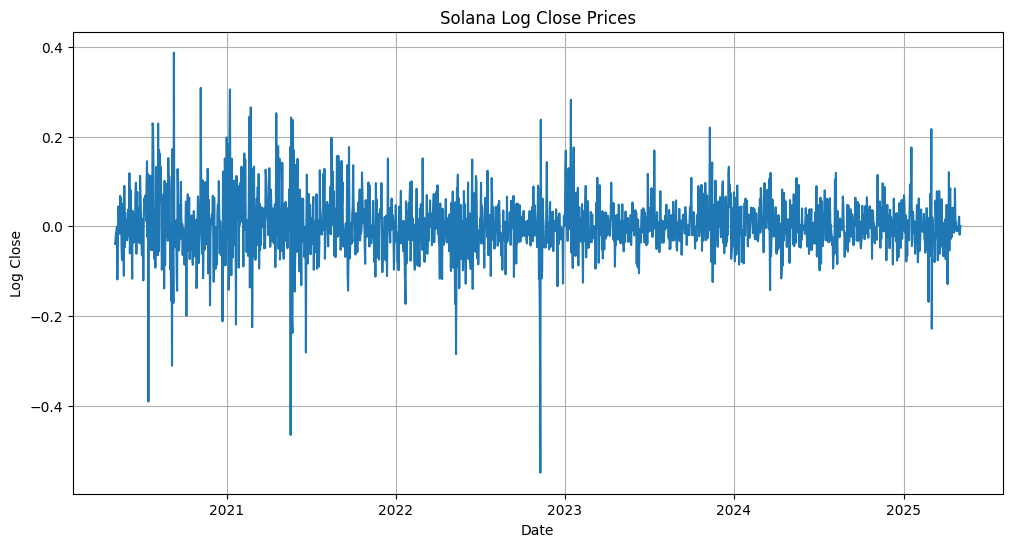

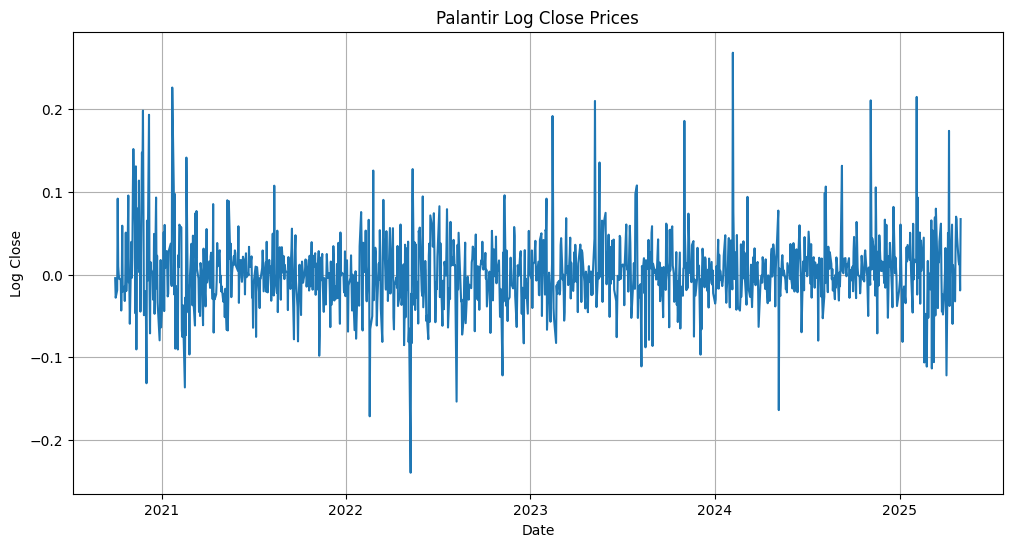

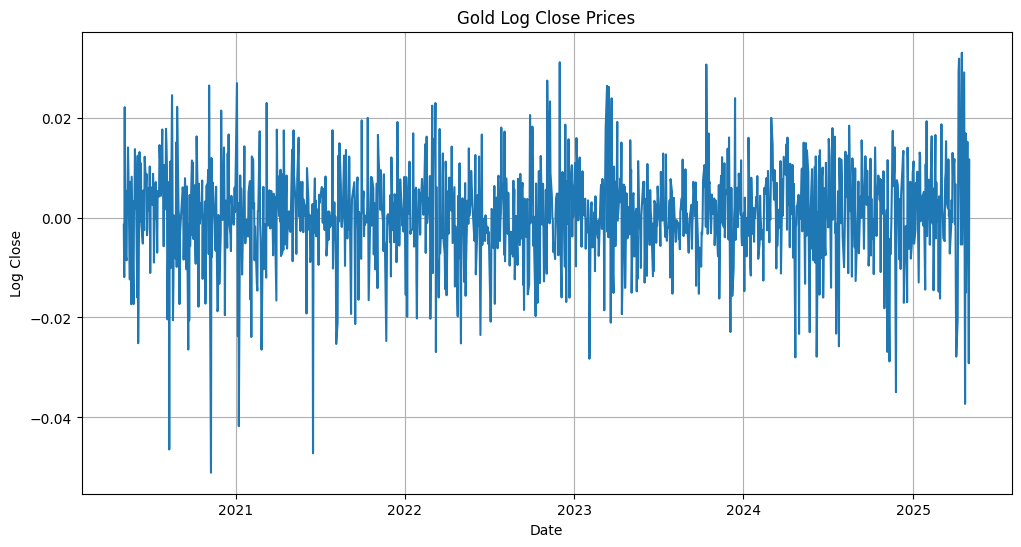

In [146]:
#Grafic randamente Solana
plt.figure(figsize=(12, 6))
plt.plot(solana_log['Close'])
plt.title('Solana Log Close Prices')
plt.xlabel('Date')
plt.ylabel('Log Close')
plt.grid(True)
plt.show()

#Grafic randamente Palantir
plt.figure(figsize=(12, 6))
plt.plot(palantir_log['Close'])
plt.title('Palantir Log Close Prices')
plt.xlabel('Date')
plt.ylabel('Log Close')
plt.grid(True)
plt.show()

#Grafic randamente Gold
plt.figure(figsize=(12, 6))
plt.plot(gold_log['Close'])
plt.title('Gold Log Close Prices')
plt.xlabel('Date')
plt.ylabel('Log Close')
plt.grid(True)
plt.show()

In [135]:
# Definim o funcție utilitară pentru extragerea momentelor
def calculeaza_momente(serie):
    serie = serie.dropna()

    mean_val = serie.mean().item()
    std_val = serie.std().item()
    var_val = serie.var().item()
    skew_val = skew(serie, bias=False).item()
    kurt_val = (kurtosis(serie, bias=False)).item()  # kurt standard
    cv_val = (std_val / abs(mean_val))

    return {
        'N': len(serie),
        'Mean': mean_val,
        'Std Deviation': std_val,
        'Variance': var_val,
        'Skewness': skew_val,
        'Kurtosis': kurt_val,
        'Coeff Variation': cv_val
    }


# Aplicăm pentru fiecare activ
sol = calculeaza_momente(solana_log['Close'])
pltr = calculeaza_momente(palantir_log['Close'])
gold = calculeaza_momente(gold_log['Close'])

# Creăm un DataFrame comparativ
momente_df = pd.DataFrame([sol, pltr, gold], index=['Solana', 'Palantir', 'Gold']).round(6)
momente_df

,N,Mean,Std Deviation,Variance,Skewness,Kurtosis,Coeff Variation
Solana,1826,0.002952,0.066002,0.004356,-0.247173,7.210742,22.356336
Palantir,1152,0.002232,0.045166,0.002040,0.674992,4.648631,20.235813
Gold,1251,0.000537,0.009827,0.000097,-0.540300,2.210162,18.305862


# **🟣 Solana**

Solana prezintă cel mai mare randament mediu zilnic (0.00295), dar și cea mai ridicată volatilitate (0.066), ceea ce indică un profil de risc ridicat. Distribuția randamentelor este leptocurtică (kurtosis = 7.21), cu cozi groase și o ușoară asimetrie negativă (skewness = -0.25), semnalând o probabilitate mai mare de scăderi bruște.

# **🔵 Palantir**

Palantir înregistrează un randament mediu pozitiv (0.00223) și o volatilitate moderată (0.0452). Coeficientul de asimetrie pozitiv (0.67) indică o tendință către creșteri abrupte, iar kurtosis-ul de 4.65 sugerează o distribuție leptocurtică, cu valori extreme mai frecvente decât în cazul unei distribuții normale.

# **🟡 Gold**

Gold are cel mai mic randament mediu (0.00054) și cea mai redusă volatilitate (0.0098), ceea ce îl confirmă ca activ defensiv. Asimetria negativă (-0.54) sugerează riscuri ușor mai mari pentru scăderi, dar kurtosis-ul de 2.21 arată o distribuție mai plată, deci mai stabilă față de celelalte două active.

In [132]:
def afiseaza_extreme(df_log_returns, n):
    """
    Afișează cele mai mici și cele mai mari n observații din coloana 'Close' a unui DataFrame de randamente log.

    Parametri:
    - df_log_returns: DataFrame (ex: solana_log)
    - n: numărul de observații extreme afișate
    """
    import pandas as pd

    # Extragem seria de randamente 'Close'
    serie = df_log_returns['Close']
    if isinstance(serie, pd.DataFrame):
        serie = serie.squeeze()
    serie = serie.dropna()

    # Cele mai mici și mai mari valori
    lowest = serie.nsmallest(n)
    highest = serie.nlargest(n)

    # Construim tabelele
    lowest_df = pd.DataFrame({
        'Value': lowest.values,
        'Date': lowest.index.date,
        'Obs': [serie.index.get_loc(x) for x in lowest.index]
    })

    highest_df = pd.DataFrame({
        'Value': highest.values,
        'Date': highest.index.date,
        'Obs': [serie.index.get_loc(x) for x in highest.index]
    })

    # Combinăm
    extremes_df = pd.concat([lowest_df.reset_index(drop=True),
                             highest_df.reset_index(drop=True)], axis=1)

    extremes_df.columns = ['Lowest Value', 'Lowest Date', 'Lowest Obs',
                           'Highest Value', 'Highest Date', 'Highest Obs']

    # Afișăm
    from IPython.display import display
    display(extremes_df)

#Extreme Solana
print("\n Extreme Solana")
afiseaza_extreme(solana_log, 10)

#extreme Palantir
print("\n Extreme Palantir")
afiseaza_extreme(palantir_log, 10)

#extreme Gold
print("\n Extreme Gold")
afiseaza_extreme(gold_log, 10)


 Extreme Solana


,Lowest Value,Lowest Date,Lowest Obs,Highest Value,Highest Date,Highest Obs
0,-0.549582,2022-11-09,918,0.387184,2020-09-09,127
1,-0.465355,2021-05-19,379,0.308867,2020-11-06,185
2,-0.390791,2020-07-16,72,0.305299,2021-01-08,248
3,-0.311053,2020-09-05,123,0.282125,2023-01-14,984
4,-0.284965,2022-05-11,736,0.265386,2021-02-22,293
5,-0.281440,2021-06-21,412,0.252295,2021-04-18,348
6,-0.237768,2021-05-23,383,0.244306,2021-02-19,290
7,-0.228588,2025-03-03,1763,0.242524,2021-05-20,380
8,-0.225035,2021-02-25,296,0.237690,2022-11-10,919
9,-0.219232,2021-01-21,261,0.236746,2021-05-24,384



 Extreme Palantir


,Lowest Value,Lowest Date,Lowest Obs,Highest Value,Highest Date,Highest Obs
0,-0.239629,2022-05-09,403,0.268510,2024-02-06,841
1,-0.171358,2022-02-17,348,0.226372,2021-01-22,77
2,-0.163850,2024-05-07,904,0.215038,2025-02-04,1090
3,-0.153569,2022-08-08,465,0.210849,2024-11-05,1030
4,-0.136446,2021-02-16,93,0.210140,2023-05-09,654
5,-0.131363,2020-12-02,43,0.198493,2020-11-25,39
6,-0.121890,2022-11-07,529,0.193441,2020-12-07,46
7,-0.121843,2025-04-04,1132,0.191912,2023-02-14,596
8,-0.113493,2025-03-06,1111,0.186001,2023-11-02,777
9,-0.111243,2025-02-24,1103,0.173945,2025-04-09,1135



 Extreme Gold


,Lowest Value,Lowest Date,Lowest Obs,Highest Value,Highest Date,Highest Obs
0,-0.051069,2020-11-09,131,0.032973,2025-04-16,1239
1,-0.047183,2021-06-17,282,0.031781,2025-04-10,1235
2,-0.046407,2020-08-11,68,0.031070,2022-12-01,646
3,-0.041753,2021-01-08,172,0.030608,2023-10-13,861
4,-0.037296,2025-04-23,1243,0.029247,2025-04-09,1234
5,-0.034959,2024-11-25,1142,0.029042,2025-04-21,1241
6,-0.029166,2025-05-01,1249,0.027397,2022-11-04,628
7,-0.028802,2024-11-11,1132,0.026892,2021-01-04,168
8,-0.028262,2023-02-03,689,0.026409,2020-11-05,129
9,-0.027990,2024-04-22,991,0.026342,2023-03-13,714


# **📉 Cele mai mari scăderi ale Solanei – „Lowest Observations”**

| Randament   | Data           | Context istoric                                                                                                                                                                                                                                                                               |
| ----------- | -------------- | --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **-54.96%** | **2022-11-09** | 🔥 **Prăbușirea FTX** – Cel mai probabilă cauză. În noiembrie 2022, platforma FTX (unde Solana era listată și susținută de Sam Bankman-Fried) a intrat în colaps, generând **panică majoră în piață**. Solana a fost una dintre cele mai afectate criptomonede, pierzând peste 50% într-o zi. |
| **-46.56%** | 2021-05-19     | 📉 **Crackdown-ul Chinei împotriva minării cripto** – În mai 2021, China a anunțat măsuri drastice împotriva activităților cripto, ceea ce a provocat **vânzări masive** în piață. Toate criptomonedele majore au suferit pierderi.                                                           |
| **-31.10%** | 2020-09-05     | ❓ Poate fi asociat cu **o retragere bruscă în altcoin-uri** după un val scurt de creștere – ar necesita verificare suplimentară, dar în acea perioadă, Ethereum și DeFi au avut mișcări volatile.                                                                                             |


# **📈 Cele mai mari creșteri ale Solanei – „Highest Observations”**

| Randament   | Data           | Context istoric                                                                                                                                                                                  |
| ----------- | -------------- | ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------ |
| **+38.71%** | **2020-09-09** | 🚀 Perioadă de **efervescență DeFi** – Solana era relativ nouă și a crescut în urma entuziasmului generalizat pentru proiecte alternative la Ethereum. Posibil lansarea unor proiecte pe Solana. |
| **+30.89%** | 2020-11-06     | 🔄 **Bull market pre-BTC halving + lansări din ecosistem** – În acea perioadă au fost raliuri majore pe toate criptomonedele.                                                                    |
| **+28.21%** | 2023-01-14     | 🔁 **Recuperare după FTX** – În ianuarie 2023, Solana a crescut puternic după ce a rezistat șocului FTX și și-a menținut dezvoltarea tehnologică.                                                |
